<a href="https://colab.research.google.com/github/PuChan-HCI/myweb/blob/main/DeepLearning-with-Pytorch/03_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--BOOK_INFORMATION-->
<img align="left" style="width:160px;height:200px;padding-right:30px;" src="https://raw.githubusercontent.com/joe-papa/pytorch-book/main/files/pytorch-book-cover.jpg">

# Image Classification with Transfer Learning
The subject of image classification has been studied in depth, and many famous models, such as the AlexNet and VGG models, are readily available through PyTorch. However, these models have been trained with the ImageNet dataset. Although ImageNet contains 1,000 different image classes, it may not contain the classes that you need to solve your image
classification problem. In this case, you can apply transfer learning, a process in which we fine-tune pretrained models with a much smaller dataset of
new images. For our next example, we will train a model to classify images of bees and ants—classes not contained in ImageNet. Bees and ants look very similar and can be difficult to distinguish.

## Data Processing
Let’s begin by loading our data, defining our transforms, and configuring our dataloaders for batch sampling. As we did earlier, we’ll leverage functions from the Torchvision library for creating the datasets, loading the data, and applying the data
transforms.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

## Downloading the data for training and validation:
Here, we use the io, urlib, and zipfile libraries to download and unzip a file to our local filesystem. After running the previous code, you should have your training and validation images in your local data/ folder. They are located in data/hymenoptera_data/train and data/hymenoptera_data/val, respectively.

In [19]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = \
  'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall('./data')

Notice that we randomly resize, crop, and flip images for training but not for validation. The “magic” numbers used in the Normalize transforms are precomputed values for the means and standard deviations.

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456,0.406],
        [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])])


Now let’s define the datasets:

In [4]:
train_dataset = datasets.ImageFolder(
          root='data/hymenoptera_data/train',
          transform=train_transforms)

val_dataset = datasets.ImageFolder(
            root='data/hymenoptera_data/val',
            transform=val_transforms)

class_names = val_dataset.classes
print(class_names)

['ants', 'bees']


We define our dataloaders for batch iteration:

In [5]:
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=4)

val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model Design
Load a pretrained model and reset final fully connected layer.

ResNet18 is designed to detect 1,000 classes, and in our case, we only need 2 classes— bees and ants. We can modify the final layer to detect 2 classes instead of 1,000 as shown in the following code:

In [6]:
model = models.resnet18(pretrained=True)
print(model.fc)

# Finetuning the ConvNet
num_ftrs = model.fc.in_features       # we read the number of features before the final layer

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)   # we change the final layer by directly setting
                                                                        # model.fc to a fully connected layer with two outputs.
print(model.fc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 155MB/s]

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=2, bias=True)


We are going to use the pretrained model as a starting point and fine-tune its parameters with new data. Since we replaced the final linear layer, its parameters are now randomly initialized.

Now we have a ResNet18 model with all weights pretrained with ImageNet images except for the last layer. Next, we need to train our model with images of bees and ants.

## Training and Validation
Before we fine-tune our model, let’s configure our training with the following code.

*The code should look familiar, with the exception of the learning rate scheduler. Here we will use a scheduler from PyTorch to adjust the learning rate of our SGD optimizer after several epochs. Using a learning rate scheduler will help our NN adjust
its weights more precisely as training goes on.*

In [22]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if \
                      torch.cuda.is_available() else "cpu")           # Move the model to a GPU if available.

model = model.to(device)
criterion = nn.CrossEntropyLoss()                   # Define our loss function.
optimizer = optim.SGD(
                    model.parameters(),
                    lr=0.001,
                    momentum=0.9)                                 # Define our optimizer algorithm.
exp_lr_scheduler = StepLR(optimizer,
                          step_size=7,
                          gamma=0.1)                                    #Use a learning rate scheduler.

The following code illustrates the entire training loop, including validation:

In [23]:
num_epochs=25

for epoch in range(num_epochs):

  model.train()                                                                         # Training loop.
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    _, preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()/inputs.size(0)
    running_corrects +=  torch.sum(preds == labels.data) / inputs.size(0)

  exp_lr_scheduler.step()                                                   # Schedule the learning rate for next the epoch of training.
  train_epoch_loss = running_loss / len(train_loader)
  train_epoch_acc = running_corrects / len(train_loader)

  model.eval()                                                                        # Validation loop.
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      loss = criterion(outputs, labels)

      running_loss += loss.item()/inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)  /inputs.size(0)

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = running_corrects.double() / len(val_loader)

  print("Train: Loss: {:.4f} Acc: {:.4f}"
    " Val: Loss: {:.4f}"
    " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

Train: Loss: 0.0816 Acc: 0.8730 Val: Loss: 0.0910 Acc: 0.8846
Train: Loss: 0.1244 Acc: 0.8033 Val: Loss: 0.1939 Acc: 0.7692
Train: Loss: 0.1358 Acc: 0.7951 Val: Loss: 0.1007 Acc: 0.8333
Train: Loss: 0.1238 Acc: 0.8074 Val: Loss: 0.0722 Acc: 0.8782
Train: Loss: 0.1404 Acc: 0.7787 Val: Loss: 0.0651 Acc: 0.9103
Train: Loss: 0.0705 Acc: 0.8730 Val: Loss: 0.1651 Acc: 0.8205
Train: Loss: 0.1133 Acc: 0.8443 Val: Loss: 0.1134 Acc: 0.8526
Train: Loss: 0.1273 Acc: 0.8484 Val: Loss: 0.2054 Acc: 0.8910
Train: Loss: 0.0621 Acc: 0.9139 Val: Loss: 0.0743 Acc: 0.9103
Train: Loss: 0.0696 Acc: 0.8934 Val: Loss: 0.0812 Acc: 0.9103
Train: Loss: 0.0646 Acc: 0.9057 Val: Loss: 0.0857 Acc: 0.9038
Train: Loss: 0.0460 Acc: 0.9098 Val: Loss: 0.0859 Acc: 0.9038
Train: Loss: 0.0492 Acc: 0.9180 Val: Loss: 0.0670 Acc: 0.9167
Train: Loss: 0.0454 Acc: 0.9221 Val: Loss: 0.0688 Acc: 0.8974
Train: Loss: 0.0696 Acc: 0.8607 Val: Loss: 0.0652 Acc: 0.9231
Train: Loss: 0.0471 Acc: 0.9303 Val: Loss: 0.0712 Acc: 0.9167
Train: L

## Testing and Deployment
Let’s test our model and deploy it by saving the model to a file. To test our model, we’ll display a batch of images and show how our model classified them, as shown in the following code:

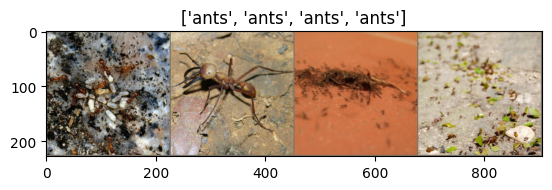

In [26]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):                          # Define a new function to plot images from
                                                                                     # our tensor images.
    inp = inp.numpy().transpose((1, 2, 0))     # Switch from C × H × W to H × W × C image formats
                                                                                     # for plotting.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean                                     # Undo the normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(val_loader))      # Grab a batch of images from our validation dataset.
out = torchvision.utils.make_grid(inputs)
class_names = val_dataset.classes

outputs = model(inputs.to(device))            # Perform classification using our fine-tuned ResNet18.
_, preds = torch.max(outputs,1)                   # Take the “winning” class.

imshow(out, title=[class_names[x] for x in preds]) # Display the input images and their predicted classes.

# Your results will vary since the val_loader will return a randomly sampled batch of images.

# Saving the model

In [10]:
torch.save(model.state_dict(), "./resnet18.pt")





---


# Alternative::Write a general function to train a model

*From the Transfer Learning for Computer Vision Tutorial (Sasank Chilamkurthy)*

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [27]:
import os

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),   data_transforms[x])
                  for x in ['train', 'val']}
# print(image_datasets)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


# Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

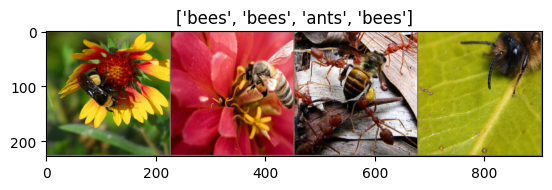

In [29]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

*   Scheduling the learning rate
*   Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [13]:
import time
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        # best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        best_model_params = "./best_model_params.pt"
        torch.save(model.state_dict(), best_model_params)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params))
    return model

# Finetuning the ConvNet
Load a pretrained model and reset final fully connected layer.

In [31]:
from torch.optim import lr_scheduler

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5519 Acc: 0.7295
val Loss: 0.2171 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5931 Acc: 0.7705
val Loss: 0.3144 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.3177 Acc: 0.8566
val Loss: 0.2984 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4274 Acc: 0.8361
val Loss: 0.3131 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.3763 Acc: 0.8566
val Loss: 0.2818 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4722 Acc: 0.8566
val Loss: 0.3805 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5798 Acc: 0.8197
val Loss: 0.3455 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4108 Acc: 0.8484
val Loss: 0.3470 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3372 Acc: 0.8443
val Loss: 0.2500 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3268 Acc: 0.8852
val Loss: 0.2696 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3163 Acc: 0.8770
val Loss: 0.3072 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2904 Acc: 0.8852
val Loss: 0.2715 Acc: 0.9216

Ep

# Visualizing the model predictions

In [37]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

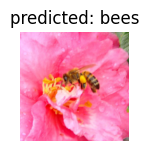

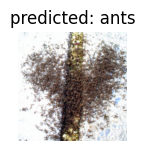

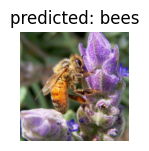

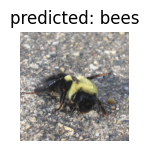

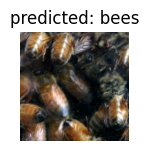

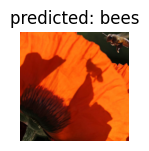

In [39]:
visualize_model(model_ft)